In [671]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [672]:
collector_df = pd.read_csv('../data/new_udp_udp1/reports.csv')
sender_df = pd.read_csv('../data/new_udp_udp1/latency_udp.csv')
# t = (164, 180)

# collector_df = pd.read_csv('../data/new_http_tcp1/reports.csv')
# sender_df = pd.read_csv('../data/new_http_tcp1/latency_http.csv')
# t = (380, 400)


flow_start_timestamps = [
    1716118168733048346,
    1716118219592875275,
    1716118243337285147,
    1716118280113960633,
    1716118324414532070
]

sender_df.columns = ['timestamp', 'latency', 'dropped']

sender_df['latency'] = sender_df['latency'].apply(lambda x: int(x * 1000))
collector_df['hop_latency'] = collector_df['hop_latency'].apply(lambda x: int(x / 1000))
collector_df['ingress_timestamp'] = collector_df['ingress_timestamp'].apply(lambda x: float(x) / 1e9)
collector_df['egress_timestamp'] = collector_df['egress_timestamp'].apply(lambda x: float(x) / 1e9)
sender_start = sender_df.iloc[0]['timestamp']
collector_start = collector_df.iloc[0]['collector_timestamp']
collector_ingress_start = collector_df.iloc[0]['ingress_timestamp']
start = min(sender_start, collector_start, collector_ingress_start)

collector_df['collector_timestamp'] -= start
sender_df['timestamp'] -= start
collector_df['ingress_timestamp'] -= start
collector_df['egress_timestamp'] -= start

for i, x in enumerate(flow_start_timestamps):
    flow_start_timestamps[i] = (float(x) / 1e9) - start
    print(flow_start_timestamps[i])

# t = (95, 107, flow_start_timestamps[0])
# t = (146, 158, flow_start_timestamps[1])
t = (169, 179, flow_start_timestamps[2])
# t = (206, 218, flow_start_timestamps[3])
# t = (250, 262, flow_start_timestamps[4])

97.14029288291931
148.0001196861267
171.74452948570251
208.52120518684387
252.82177662849426


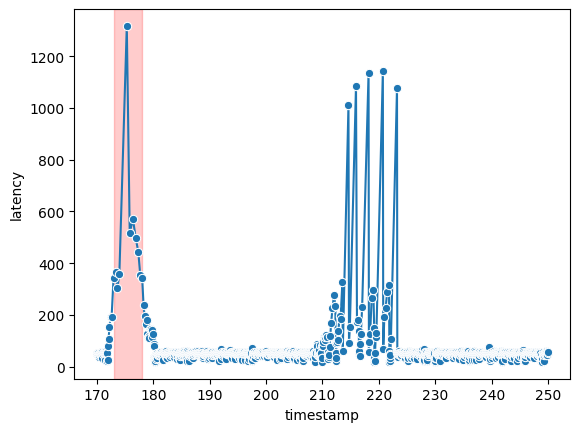

In [673]:
def compute_qos_violation_time_ranges(sender_df: pd.DataFrame, violation_threshold=400) -> list[tuple[float, float]]:
    violation_ranges = []
    start = None
    for i in range(len(sender_df)):
        is_violation = sender_df.iloc[i]['latency'] > violation_threshold
        if is_violation and start is None:
            start = i
        elif not is_violation and start is not None:
            if i - start > 1:
                violation_ranges.append([sender_df.iloc[start]['timestamp'], sender_df.iloc[i - 1]['timestamp']])
            start = None
    if start is not None and start < len(sender_df) - 1:
        violation_ranges.append([sender_df.iloc[start]['timestamp'], sender_df.iloc[len(sender_df) - 1]['timestamp']])

    return violation_ranges

def display_qos_violations(violation_ranges: list[tuple[float, float]], ax, delay=0, padding=0):
    for start, end in violation_ranges: 
        start = start - delay - padding
        end = end - delay + padding
        ax.axvspan(start, end, color='red', alpha=0.2)
    
def _test_show_qos_violations(sender_df: pd.DataFrame, collector_df: pd.DataFrame, violation_threshold=400, collector_x='collector_timestamp'):
    sdf = sender_df.copy()
    fig, ax = plt.subplots(1, 1)
    sns.lineplot(data=sdf, x='timestamp', y='latency', marker='o', ax=ax)
    violation_ranges = compute_qos_violation_time_ranges(sender_df, violation_threshold=300)
    display_qos_violations(violation_ranges, ax)

_test_show_qos_violations(sender_df[(sender_df['timestamp'] > 170) & (sender_df['timestamp'] < 250)], collector_df)

<Axes: xlabel='collector_timestamp', ylabel='hop_latency'>

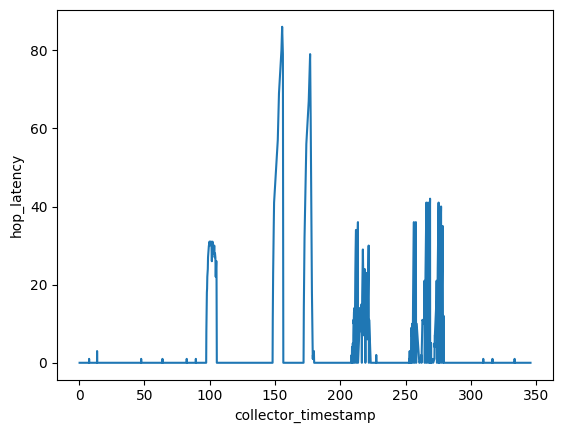

In [674]:
sns.lineplot(data=collector_df[(collector_df['switch_id']==1) & (collector_df['l1_egress_port_id']==3)], x='collector_timestamp', y='hop_latency')

<Axes: xlabel='collector_timestamp', ylabel='queue_occupancy'>

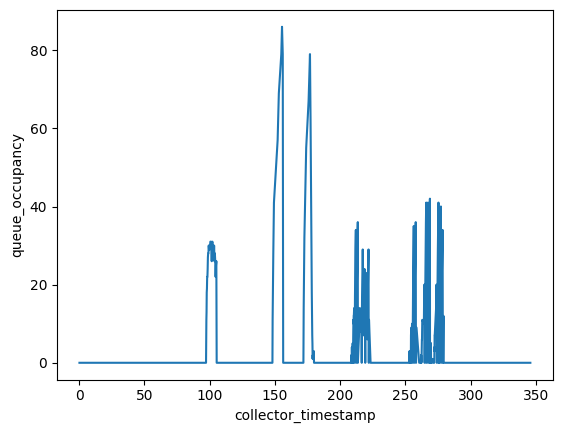

In [675]:
sns.lineplot(data=collector_df[(collector_df['switch_id']==1) & (collector_df['l1_egress_port_id']==3)], x='collector_timestamp', y='queue_occupancy')

<Axes: xlabel='timestamp', ylabel='latency'>

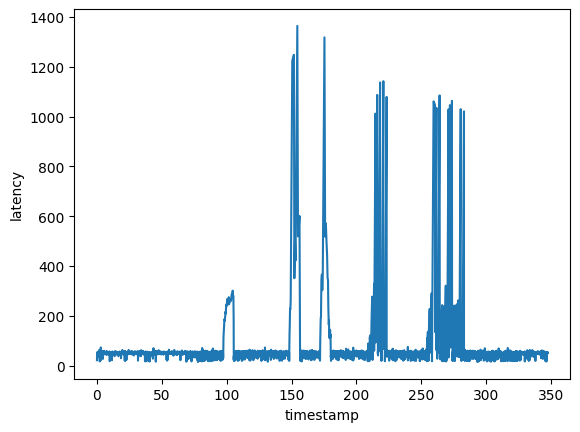

In [676]:
sns.lineplot(data=sender_df, x='timestamp', y='latency')

In [677]:

switch_name_to_id = {"r7": 1, "r2": 2, "r10": 3, "r9": 5, "r3": 6, "r6": 9, "r1": 0, "r8": 4, "r4": 7, "r5": 8}
switch_id_to_name = {v: k for k, v in switch_name_to_id.items() if k in ['r1', 'r7', 'r3', 'r5', 'r9']}
print(switch_id_to_name)

port_map = {
    "0_1": "s1-s7",
    "0_2": "s1-w1",
    "0_3": "s1-w2",
    "1_0": "s7-s1",
    "1_1": "s7-s2",
    "1_3": "s7-s10",
    "6_1": "s3-s8",
    "6_2": "s3-w5",
    "6_3": "s3-w6",
    "8_1": "s5-s9",
    "8_2": "s5-w9",
    "8_3": "s5-w10",
    "5_1": "s9-s5",
    "5_2": "s9-s6",
    "5_3": "s9-s10",
}

{1: 'r7', 5: 'r9', 6: 'r3', 0: 'r1', 8: 'r5'}


In [678]:
collector_df['port_key'] = collector_df.apply(lambda row: port_map[f'{row["switch_id"]}_{row["l1_egress_port_id"]}'], axis=1)

In [679]:
collector_df['port_key'].unique()

array(['s1-s7', 's7-s10', 's1-w1', 's3-s8', 's7-s2', 's1-w2', 's9-s6',
       's5-s9', 's9-s5'], dtype=object)

<Axes: xlabel='collector_timestamp', ylabel='hop_latency'>

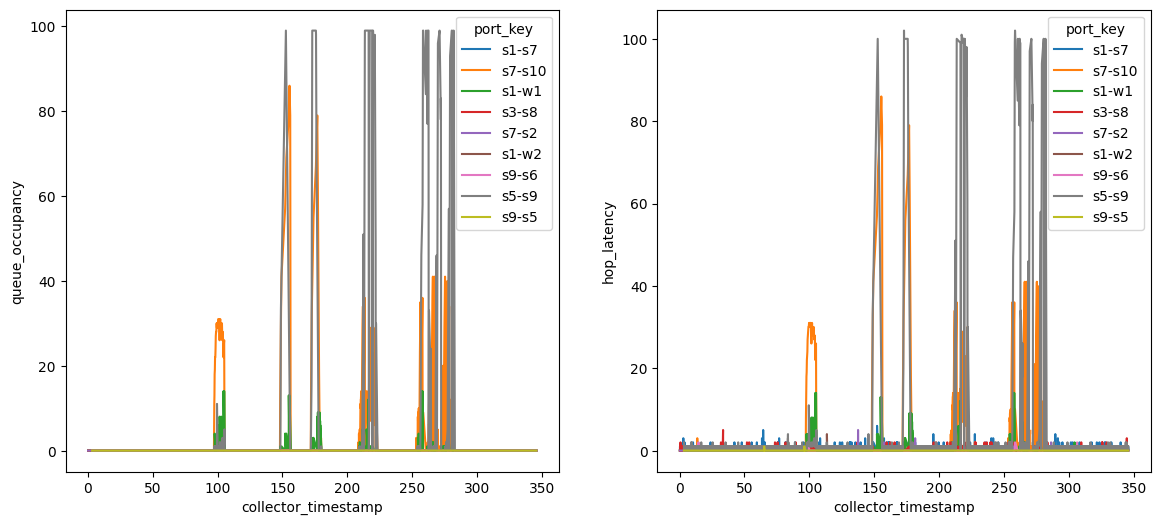

In [680]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.lineplot(ax=ax[0], data=collector_df, x='collector_timestamp', y='queue_occupancy', hue='port_key', legend=True, estimator=None, n_boot=0)
sns.lineplot(ax=ax[1], data=collector_df, x='collector_timestamp', y='hop_latency', hue='port_key', legend=True, estimator=None, n_boot=0)

<Axes: xlabel='collector_timestamp', ylabel='hop_latency'>

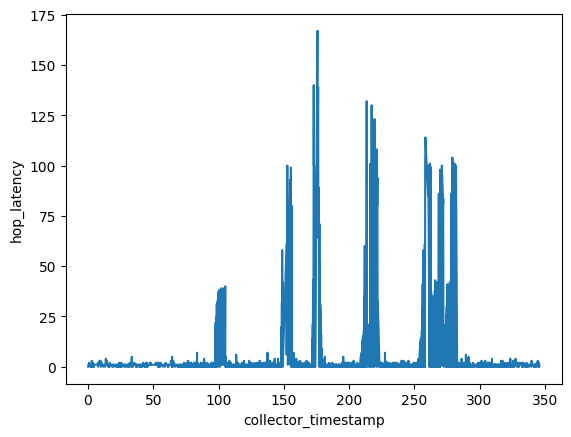

In [681]:
grouped_df = collector_df.groupby(by='flow_id').agg({'hop_latency': 'sum', 'collector_timestamp': 'first'})
sns.lineplot(data=grouped_df, x='collector_timestamp', y='hop_latency')


In [682]:
def sub_dfs(sender_df: pd.DataFrame, collector_df: pd.DataFrame, t) -> tuple[pd.DataFrame, pd.DataFrame, float]:
    dfs = []
    for df in (sender_df, collector_df):
        col_name = 'timestamp'
        if col_name not in df.columns:
            col_name = 'collector_timestamp'
        sdf = df[(df[col_name] > t[0]) & (df[col_name] < t[1])].copy()
        dfs.append(sdf)
    sender_df, collector_df = dfs
    start = min(sender_df.iloc[0]['timestamp'], collector_df.iloc[0]['collector_timestamp'], collector_df.iloc[0]['ingress_timestamp'])
    sender_df['timestamp'] -= start
    collector_df['collector_timestamp'] -= start
    collector_df['ingress_timestamp'] -= start
    collector_df['egress_timestamp'] -= start
    return sender_df, collector_df, t[2] - start, start

In [683]:
sub_sdf, sub_cdf, elephant_start, cur_experiment_start = sub_dfs(sender_df, collector_df, t)

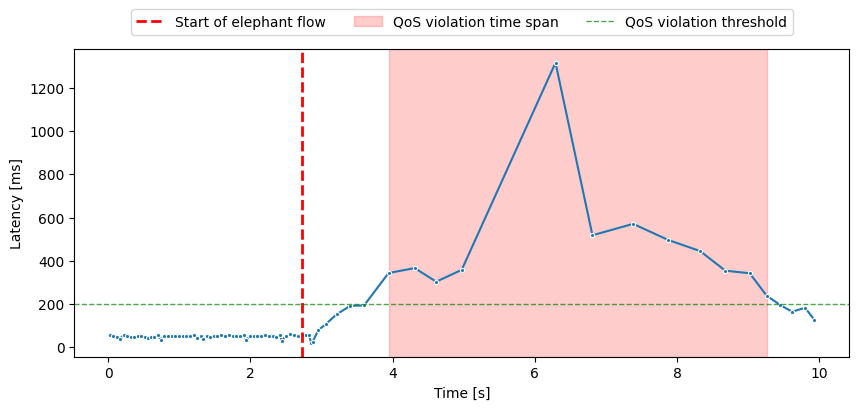

In [684]:
violation_ranges = compute_qos_violation_time_ranges(sub_sdf, violation_threshold=200)
fig, ax = plt.subplots(1,1, figsize=(10, 4))
sns.lineplot(data=sub_sdf, x='timestamp', y='latency', ax=ax, marker='o', markersize=3)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Latency [ms]")
ax.axvline(elephant_start, color='red', linestyle='--', linewidth=2)
# ax.axvline(elephant_start+8.2, color='red', linestyle='--', linewidth=2)
ax.axhline(200, color='green', alpha=0.7, linestyle='--', linewidth=1)
event_patch = mpatches.Patch(color='red', alpha=0.2, label='QoS violation time span')
# Custom legend for the dashed green vertical line
start_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Start of elephant flow')
violation_thresh_line = mlines.Line2D([], [], color='green', alpha=0.7, linestyle='--', linewidth=1, label='QoS violation threshold')

# Add the legend to the plot
ax.legend(handles=[start_line, event_patch, violation_thresh_line], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

display_qos_violations(violation_ranges, ax)

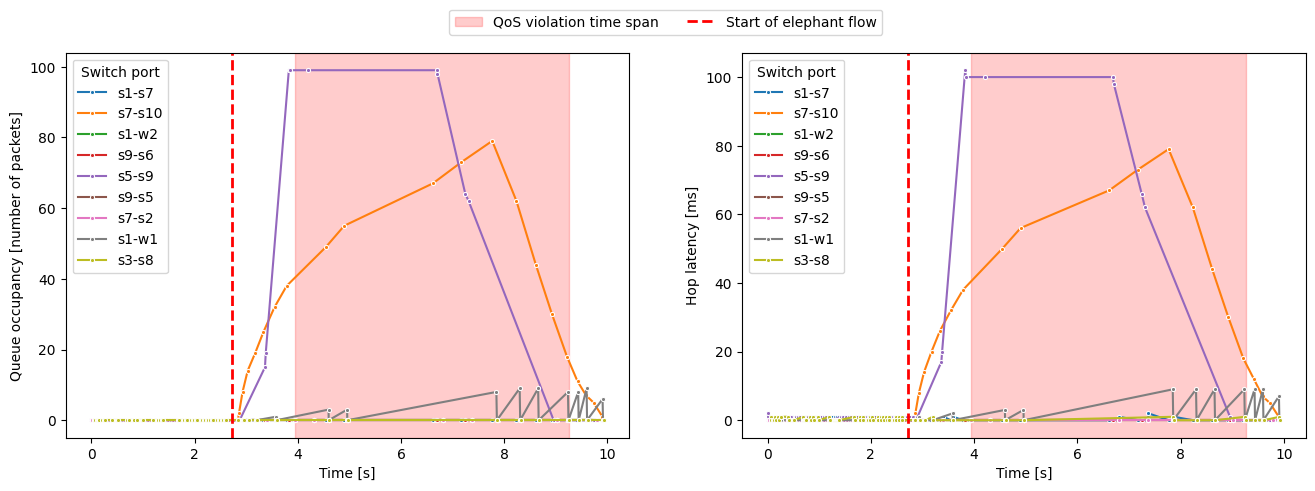

In [685]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
N = len(collector_df)
sns.lineplot(ax=ax[0], data=sub_cdf, x='ingress_timestamp', y='queue_occupancy', hue='port_key', legend=True, estimator=None, n_boot=0, marker='o', markersize=3)
sns.lineplot(ax=ax[1], data=sub_cdf, x='ingress_timestamp', y='hop_latency', hue='port_key', legend=True, estimator=None, n_boot=0, marker='o', markersize=3)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Queue occupancy [number of packets]")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Hop latency [ms]")
for a in ax:
    a.legend_.set_title("Switch port")
display_qos_violations(violation_ranges, ax[0], padding=0)
display_qos_violations(violation_ranges, ax[1], padding=0)

for a in ax:
    a.axvline(elephant_start, color='red', linestyle='--', linewidth=2)
event_patch = mpatches.Patch(color='red', alpha=0.2, label='QoS violation time span')
# Custom legend for the dashed green vertical line
start_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Start of elephant flow')

# Place the combined legend in the middle
fig.legend(handles=[event_patch, start_line], loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2)


<Axes: xlabel='timestamp', ylabel='dropped'>

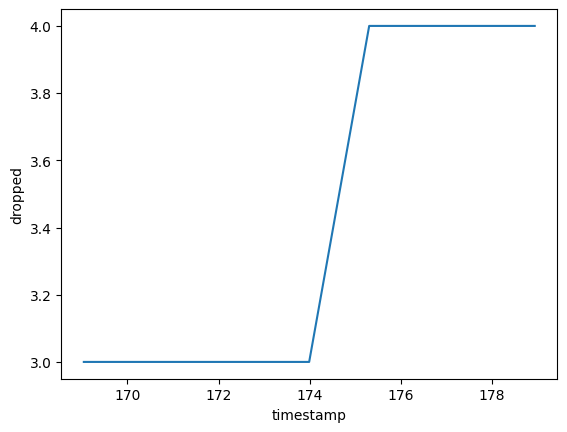

In [686]:
sns.lineplot(data=sender_df[(sender_df['timestamp'] > t[0]) & (sender_df['timestamp'] < t[1])], x='timestamp', y='dropped')

In [687]:
port_key_map_v2 = {
    'r1_r7': 's1-s7',
    'r1_tree-worker2': 's1-w1',
    'r1_tree-worker11': '11-w2',
    'r7_r1': 's7-s1',
    'r7_r10': 's7-s10',
    'r9_r10': 's9-s10',
    'r9_r5': 's9-s5',
    'r3_r8': 's3-s8',
    'r5_r9': 's5-s9'
}

In [688]:
cols = ['timestamp', 'averagePathLatency', 'onePercentileSlowestPathLatency', 'port_key', 'averageLatency',
        'onePercentileSlowestLatency', 'onePercentileLargestQueueFillState', 'averageQueueFillState', 'packets']
rows = []
import json
max_i = 2149
for i in range(max_i+1):
    with open(f'./../data/new_udp_udp1/logs{i}.json', 'r') as f:
        data = json.load(f)
        base_row = [
            data['createdAt'] - start,
            data['windowMetrics']['averagePathLatencyMicroS'] / 1000,
            data['windowMetrics']['onePercentileSlowestPathLatencyMicroS'] / 1000,
        ]
        for dm in data['windowMetrics']['deviceMetrics']:
            for pm in dm['portMetrics']:
                row = [*base_row]
                port_key = port_key_map_v2[f'{dm["deviceName"]}_{pm["toDevice"]}']
                row.extend([
                    port_key,
                    pm['averageLatencyMicroS'] / 1000,
                    pm['onePercentileSlowestLatencyMicroS'] / 1000,
                    pm['onePercentileLargestQueueFillState'],
                    pm['averageQueueFillState'],
                    pm['packets'],
                ])
                rows.append(row)

summary_df = pd.DataFrame.from_records(rows, columns=cols)
summary_df.head()

,timestamp,averagePathLatency,onePercentileSlowestPathLatency,port_key,averageLatency,onePercentileSlowestLatency,onePercentileLargestQueueFillState,averageQueueFillState,packets
0,77.407244,4.425,7.135,s1-s7,0.413,0.907,0,0,268
1,77.407244,4.425,7.135,s1-w1,0.378,0.847,0,0,100
2,77.407244,4.425,7.135,11-w2,0.352,0.747,0,0,58
3,77.407244,4.425,7.135,s7-s1,0.420,0.749,0,0,109
4,77.407244,4.425,7.135,s7-s10,0.350,0.834,0,0,108


In [689]:
def sub_summary_df(summary_df: pd.DataFrame, t, t0) -> pd.DataFrame:
    sdf = summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1])].copy()
    sdf['timestamp'] -= t0
    return sdf

<Axes: xlabel='timestamp', ylabel='onePercentileSlowestPathLatency'>

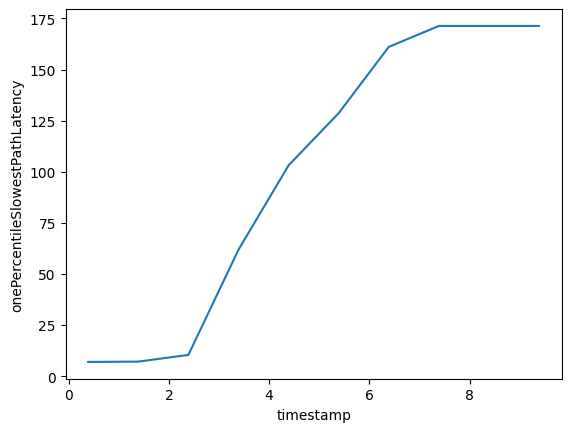

In [690]:
sns.lineplot(data=sub_summary_df(summary_df, t, cur_experiment_start), x='timestamp', y='onePercentileSlowestPathLatency', errorbar=None)

In [691]:
summary_df['port_key'].unique()

array(['s1-s7', 's1-w1', '11-w2', 's7-s1', 's7-s10', 's9-s10', 's9-s5',
       's3-s8', 's5-s9'], dtype=object)

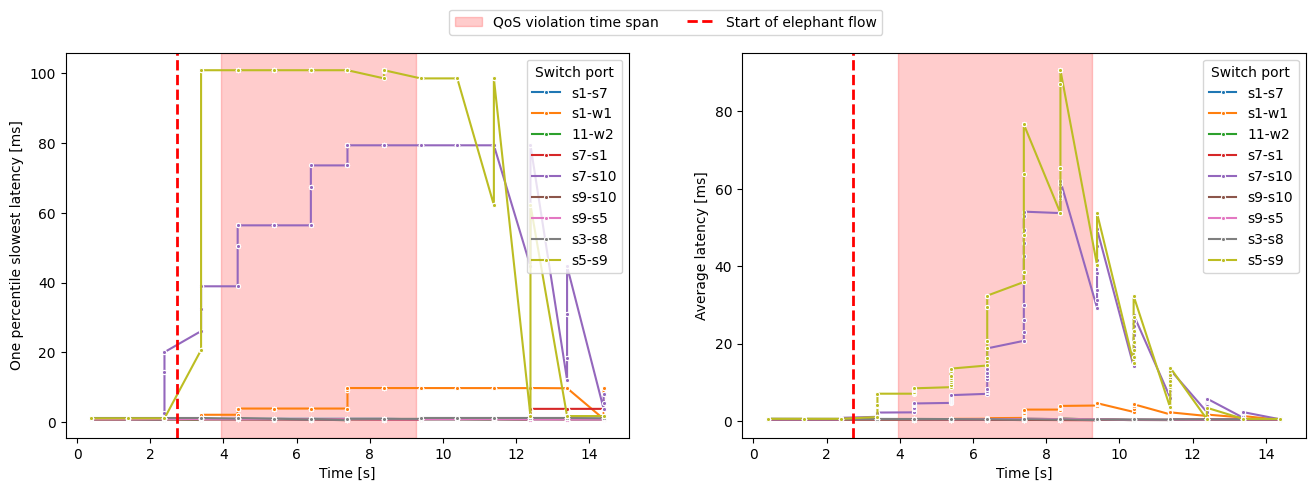

In [692]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
N = len(collector_df)
sns.lineplot(ax=ax[0], data=sub_summary_df(summary_df, [t[0], t[1] + 5], cur_experiment_start), x='timestamp', y='onePercentileSlowestLatency', hue='port_key', legend=True, estimator=None, n_boot=0, marker='o', markersize=3)
sns.lineplot(ax=ax[1], data=sub_summary_df(summary_df, [t[0], t[1] + 5], cur_experiment_start), x='timestamp', y='averageLatency', hue='port_key', legend=True, estimator=None, n_boot=0, marker='o', markersize=3)
sns.move_legend(ax[0], "upper right")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("One percentile slowest latency [ms]")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Average latency [ms]")
for a in ax:
    a.legend_.set_title("Switch port")
display_qos_violations(violation_ranges, ax[0], padding=0)
display_qos_violations(violation_ranges, ax[1], padding=0)

for a in ax:
    a.axvline(elephant_start, color='red', linestyle='--', linewidth=2)
event_patch = mpatches.Patch(color='red', alpha=0.2, label='QoS violation time span')
# Custom legend for the dashed green vertical line
start_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Start of elephant flow')

# Place the combined legend in the middle
fig.legend(handles=[event_patch, start_line], loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2)

<Axes: xlabel='timestamp', ylabel='averageQueueFillState'>

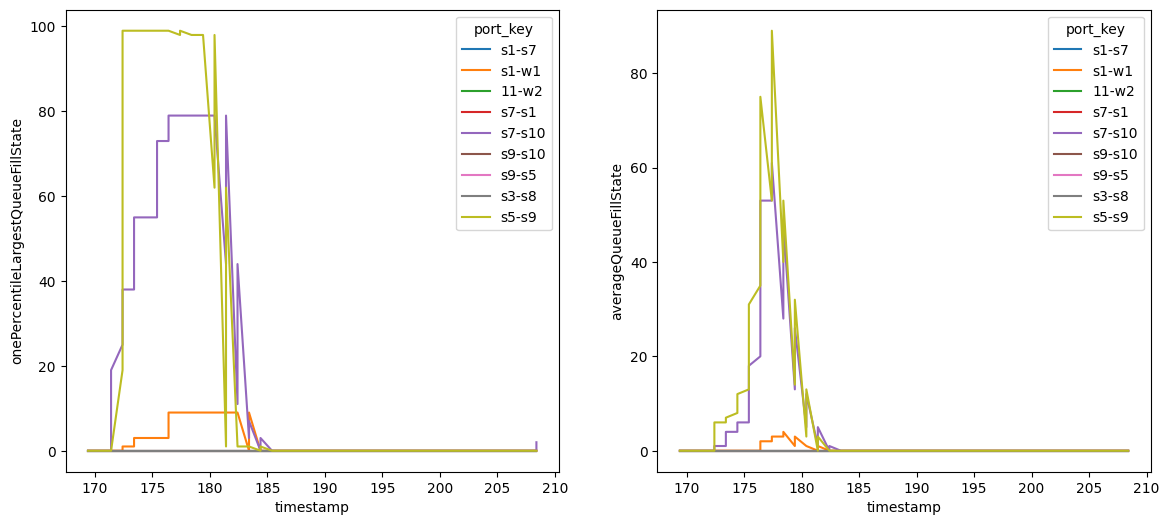

In [693]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
N = len(collector_df)
sns.lineplot(ax=ax[0], data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1] + 30)], x='timestamp', y='onePercentileLargestQueueFillState', hue='port_key', legend=True, estimator=None, n_boot=0)
sns.lineplot(ax=ax[1], data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1] + 30)], x='timestamp', y='averageQueueFillState', hue='port_key', legend=True, estimator=None, n_boot=0)